# Setup

In [6]:
import os
import torch
import pandas as pd
import whisper
from jiwer import wer, Compose, ToLowerCase, RemovePunctuation, RemoveMultipleSpaces
from tqdm import tqdm

# Whisper-Modell laden
model_size = "tiny"
device = "cpu"
model = whisper.load_model(model_size, device=device)

# WER-Normalisierung
transform = Compose([
    ToLowerCase(),
    RemovePunctuation(),
    RemoveMultipleSpaces()
])

# Subsets mit ihren Pfaden
subsets = {
    "cv_10h_en": {
        "audio_dir": "../../audio_files/common_voice/10h/cv_10h_en",
        "tsv_path": "../../audio_files/common_voice/raw/cv-corpus-21.0-en-2025-03-14/en/validated.tsv"
    },
    "cv_10h_en_delta": {
        "audio_dir": "../../audio_files/common_voice/10h/cv_10h_en_delta",
        "tsv_path": "../../audio_files/common_voice/raw/cv-corpus-22.0-en-delta-2025-06-20/en/validated.tsv"
    },
    "cv_10h_de": {
        "audio_dir": "../../audio_files/common_voice/10h/cv_10h_de",
        "tsv_path": "../../audio_files/common_voice/raw/cv-corpus-22.0-de-2025-06-20/de/validated.tsv"
    },
    "cv_10h_de_delta": {
        "audio_dir": "../../audio_files/common_voice/10h/cv_10h_de_delta",
        "tsv_path": "../../audio_files/common_voice/raw/cv-corpus-22.0-de-delta-2025-06-20/de/validated.tsv"
    }
}

output_dir = "../../results/subset_10h/word_error_rates"
os.makedirs(output_dir, exist_ok=True)

# WER-Funktion

In [7]:
def compute_wer_for_subset(subset_name, audio_dir, tsv_path):
    df = pd.read_csv(tsv_path, sep="\t")
    df = df[df["path"].isin(os.listdir(audio_dir))]

    results = []

    for _, row in tqdm(df.iterrows(), total=len(df), desc=subset_name):
        filename = row["path"]
        reference = str(row["sentence"]).strip()
        file_path = os.path.join(audio_dir, filename)

        if not os.path.exists(file_path):
            continue

        try:
            result = model.transcribe(file_path, language="en" if "en" in subset_name else "de", fp16=False)
            hypothesis = result["text"].strip()
            wer_score = wer(transform(reference), transform(hypothesis))

            results.append({
                "subset": subset_name,
                "filename": filename,
                "reference": reference,
                "hypothesis": hypothesis,
                "wer": wer_score
            })

        except Exception as e:
            print(f"Fehler bei {filename}: {e}")
            continue

    return pd.DataFrame(results)

# WER-Berechnung

In [8]:
all_dfs = []

for name, paths in subsets.items():
    df_subset = compute_wer_for_subset(name, paths["audio_dir"], paths["tsv_path"])
    df_subset.to_csv(os.path.join(output_dir, f"{name}_wer.csv"), index=False)
    all_dfs.append(df_subset)

# Optional zusammenführen
df_all = pd.concat(all_dfs, ignore_index=True)
df_all.to_csv(os.path.join(output_dir, "wer_all_subsets_combined.csv"), index=False)

print("\n✅ WER-Berechnung abgeschlossen und gespeichert.")

/var/folders/20/0f1z0fvn1hvgz14x2k0l0zz00000gn/T/ipykernel_41132/3065741132.py:2: DtypeWarning: Columns (4,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(tsv_path, sep="\t")
cv_10h_en_delta: 100%|██████████████████████████| 45/45 [00:12<00:00,  3.51it/s]
/var/folders/20/0f1z0fvn1hvgz14x2k0l0zz00000gn/T/ipykernel_41132/3065741132.py:2: DtypeWarning: Columns (4,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(tsv_path, sep="\t")
cv_10h_de_delta: 100%|██████████████████████| 1020/1020 [05:22<00:00,  3.16it/s]


✅ WER-Berechnung abgeschlossen und gespeichert.


# Plots

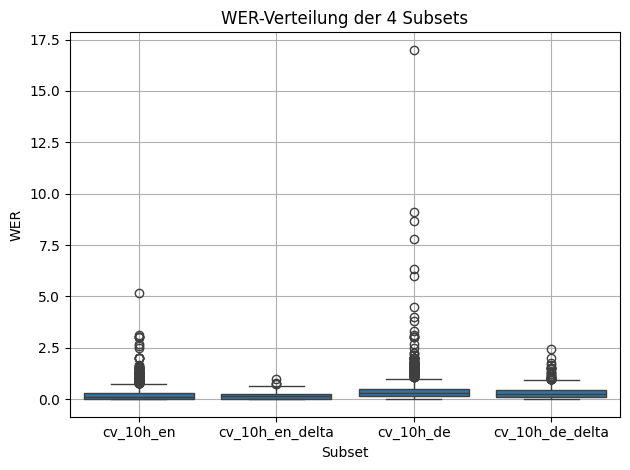

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(data=df_all, x="subset", y="wer")
plt.title("WER-Verteilung der 4 Subsets")
plt.ylabel("WER")
plt.xlabel("Subset")
plt.grid(True)
plt.tight_layout()
plt.show()

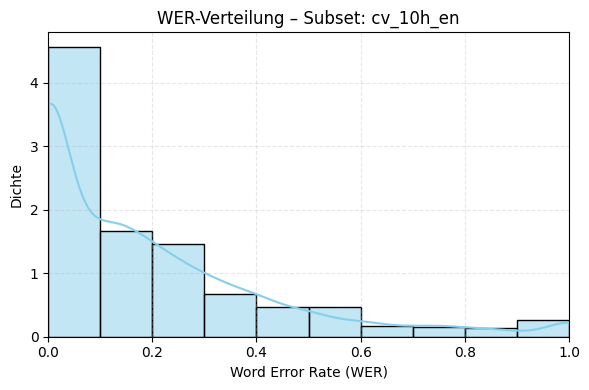

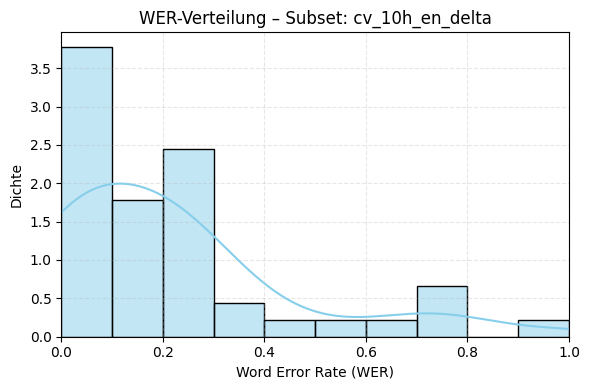

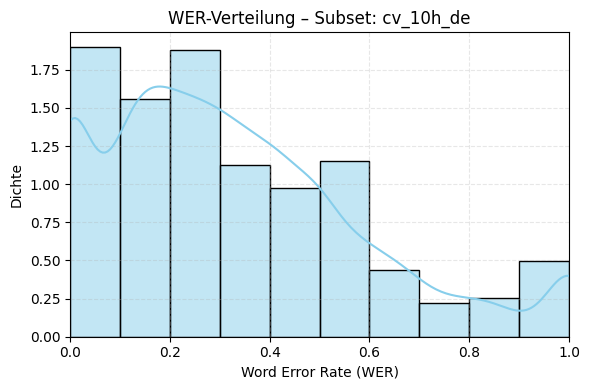

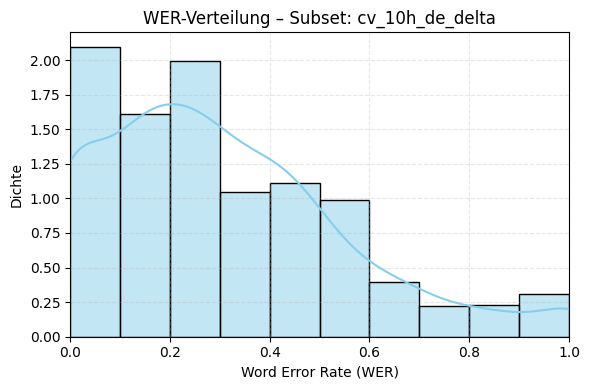

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_wer_distribution(df, subset_name):
    # Subset filtern
    subset_df = df[df["subset"] == subset_name].copy()
    
    # WER-Werte bereinigen
    subset_df = subset_df[subset_df["wer"].notna()]
    subset_df = subset_df[subset_df["wer"].apply(lambda x: 0 <= x <= 1)]

    if subset_df.empty:
        print(f"⚠️ Keine gültigen WER-Werte für Subset '{subset_name}' vorhanden.")
        return

    # Plot
    plt.figure(figsize=(6, 4))
    sns.histplot(
        data=subset_df,
        x="wer",
        kde=True,
        stat="density",
        bins=10,
        color="skyblue",
        edgecolor="black"
    )
    plt.title(f"WER-Verteilung – Subset: {subset_name}")
    plt.xlabel("Word Error Rate (WER)")
    plt.ylabel("Dichte")
    plt.xlim(0, 1)
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.tight_layout()
    plt.show()


plot_wer_distribution(df_all, "cv_10h_en")
plot_wer_distribution(df_all, "cv_10h_en_delta")
plot_wer_distribution(df_all, "cv_10h_de")
plot_wer_distribution(df_all, "cv_10h_de_delta")

# Statistiken

In [17]:
def compute_wer_statistics(df, subset_name):
    subset_df = df[df["subset"] == subset_name]
    wer_values = subset_df["wer"].dropna()

    if wer_values.empty:
        print(f"⚠️ Keine gültigen WER-Werte für Subset: {subset_name}")
        return None

    stats = {
        "Subset": subset_name,
        "Anzahl": len(wer_values),
        "Mittelwert": wer_values.mean(),
        "Median": wer_values.median(),
        "Standardabweichung": wer_values.std(),
        "Minimum": wer_values.min(),
        "Maximum": wer_values.max(),
        "25. Perzentil": wer_values.quantile(0.25),
        "75. Perzentil": wer_values.quantile(0.75),
    }

    return stats

In [18]:
subsets = ["cv_10h_en", "cv_10h_en_delta", "cv_10h_de", "cv_10h_de_delta"]
wer_stats_list = [compute_wer_statistics(df_all, s) for s in subsets]

# In DataFrame umwandeln zur besseren Ansicht
import pandas as pd
wer_stats_df = pd.DataFrame(wer_stats_list)
wer_stats_df

,Subset,Anzahl,Mittelwert,Median,Standardabweichung,Minimum,Maximum,25. Perzentil,75. Perzentil
0,cv_10h_en,5065,0.210488,0.125000,0.295336,0.0,5.166667,0.000000,0.300000
1,cv_10h_en_delta,45,0.217258,0.166667,0.239467,0.0,1.000000,0.000000,0.272727
2,cv_10h_de,6340,0.367422,0.285714,0.442936,0.0,17.000000,0.142857,0.500000
3,cv_10h_de_delta,1020,0.326098,0.272727,0.290593,0.0,2.428571,0.125000,0.454545


In [19]:
tsv_files = set(df["path"])
audio_files = set(os.listdir(audio_dir))
common_files = tsv_files.intersection(audio_files)

print("Dateien im .tsv:", len(tsv_files))
print("Dateien im Audio-Ordner:", len(audio_files))
print("Treffer:", len(common_files))

NameError: name 'df' is not defined

In [20]:
import pandas as pd
import os

tsv_path = "../../audio_files/common_voice/raw/cv-corpus-22.0-en-delta-2025-06-20/en/validated.tsv"
audio_dir = "../../audio_files/common_voice/10h/cv_10h_en_delta"

df = pd.read_csv(tsv_path, sep="\t")
valid_files = set(os.listdir(audio_dir))

# Nur Dateien, die tatsächlich im Audio-Ordner liegen
df_valid = df[df["path"].isin(valid_files)]
print(f"Anzahl validierter Audiodateien im EN Delta-Subset: {len(df_valid)}")

Anzahl validierter Audiodateien im EN Delta-Subset: 45


In [21]:
import pandas as pd
import os

tsv_path = "../../audio_files/common_voice/raw/cv-corpus-22.0-de-delta-2025-06-20/de/validated.tsv"
audio_dir = "../../audio_files/common_voice/10h/cv_10h_de_delta"

df = pd.read_csv(tsv_path, sep="\t")
valid_files = set(os.listdir(audio_dir))

# Nur Dateien, die tatsächlich im Audio-Ordner liegen
df_valid = df[df["path"].isin(valid_files)]
print(f"Anzahl validierter Audiodateien im DE Delta-Subset: {len(df_valid)}")

Anzahl validierter Audiodateien im DE Delta-Subset: 1020
